# Netflix Movie Recommendation

This project aims to build a recommendation system for Netflix movies. The [Netflix dataset](https://www.kaggle.com/netflix-inc/netflix-prize-data) is used. More precisely, only a subset of it is used as this dataset is huge and does not fit into the memory provided by Google Colab.

Recommendations are suggested based on **collaborative filtering using SVD**.

References:
- https://www.kaggle.com/laowingkin/netflix-movie-recommendation
- https://www.kaggle.com/gspmoreira/recommender-systems-in-python-101#Collaborative-Filtering-model

## Libraries

Let us install the [Surprise](http://surpriselib.com/) library, which we will use to build a matrix factorization based model, as well as import other classic libraries.

In [ ]:
!pip -q install scikit-surprise

In [ ]:
import gc
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import sys
%matplotlib inline

from IPython.display import display

from surprise import Dataset, Reader, SVD
from surprise import accuracy
from surprise.model_selection import cross_validate, train_test_split

## Data Loading & Processing

First, we load the dataset (a subset of the whole dataset) and format it to a convenient way for further usage. In particular, we add a `MovieID` column and change column types to maximize memory efficiency. We also split the `Date` column into `Year`, `Month` and `Day` columns.

`probe.txt` and `qualifying.txt`. define a validation and test set. However, we will not use them here. The validation set will be created simply by randomly selecting a subset of the available data.

In [4]:
def add_movie_id(df, dtype):
    movie_ids = df.loc[df.iloc[:, 0].str.contains(':'), df.columns[0]].str.rstrip(':').astype(np.uint16)
    res = df.drop(index=movie_ids.index).astype(dtype)
    movie_ids2 = np.empty(res.shape[0], dtype=np.uint16)
    start = 0
    for i in range(movie_ids.index.size):
        if i == movie_ids.index.size - 1:
            movie_ids2[start:] = movie_ids.iloc[i]
        else:
            end = start + movie_ids.index[i+1] - movie_ids.index[i] - 1
            movie_ids2[start:end] = movie_ids.iloc[i]
            start = end
    res.insert(0, 'MovieID', movie_ids2)
    res = res.reset_index(drop=True)

    return res

def format_date(df):
    dates = df['Date'].to_list()
    res = df.drop(columns='Date')
    dates = [[int(x) for x in date.split('-')] for date in dates]
    dates = np.array(dates, dtype=np.int16)
    res[['Year', 'Month', 'Day']] = pd.DataFrame(dates)
    res = res.astype({'Month': np.uint8, 'Day': np.uint8})

    return res

def read_data(path):
    df = pd.read_csv(path, names=['CustomerID', 'Rating', 'Date'])
    df = add_movie_id(df, {'CustomerID': np.uint32, 'Rating': np.uint8})
    df = format_date(df)

    return df

# paths = ['combined_data_1.txt', 'combined_data_2.txt', 'combined_data_3.txt', 'combined_data_4.txt']
paths = ['combined_data_1.txt']
data = [read_data(path) for path in paths]
data = pd.concat(data, ignore_index=True)
data

,MovieID,CustomerID,Rating,Year,Month,Day
0,1,1488844,3,2005,9,6
1,1,822109,5,2005,5,13
2,1,885013,4,2005,10,19
3,1,30878,4,2005,12,26
4,1,823519,3,2004,5,3
...,...,...,...,...,...,...
24053759,4499,2591364,2,2005,2,16
24053760,4499,1791000,2,2005,2,10
24053761,4499,512536,5,2005,7,27
24053762,4499,988963,3,2005,12,20


We also load the titles corresponding to each movie ID.

In [5]:
titles = pd.read_csv('movie_titles.csv', encoding="ISO-8859-1", header=None, names=['MovieID', 'Year (release)', 'Name'])
titles = titles.astype({'MovieID': np.uint16})
titles

,MovieID,Year (release),Name
0,1,2003.0,Dinosaur Planet
1,2,2004.0,Isle of Man TT 2004 Review
2,3,1997.0,Character
3,4,1994.0,Paula Abdul's Get Up & Dance
4,5,2004.0,The Rise and Fall of ECW
...,...,...,...
17765,17766,2002.0,Where the Wild Things Are and Other Maurice Se...
17766,17767,2004.0,Fidel Castro: American Experience
17767,17768,2000.0,Epoch
17768,17769,2003.0,The Company


Now, let's analyze the data.

In [6]:
print(f"Dataset: {data.shape[0]} movie reviews, {data['MovieID'].nunique()} movies, " +
      f"{data['CustomerID'].nunique()} customers")

Dataset: 24053764 movie reviews, 4499 movies, 470758 customers


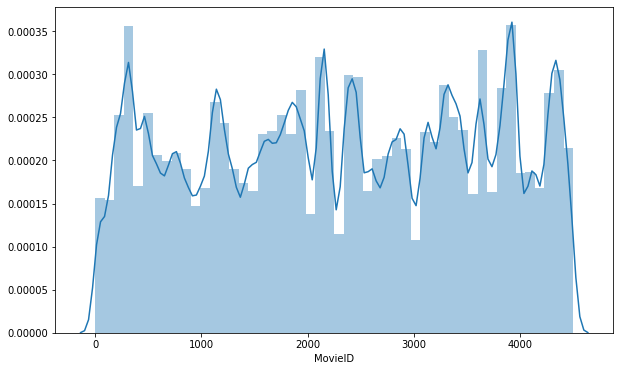

In [7]:
fig, ax = plt.subplots(figsize=(10, 6))
_ = sns.distplot(data['MovieID'], ax=ax)

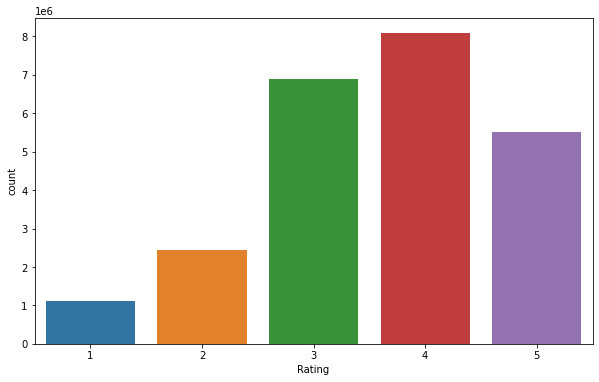

In [8]:
fig, ax = plt.subplots(figsize=(10, 6))
_ = sns.countplot(data['Rating'], ax=ax)

Some movies have more reviews than others and most of the reviews gave a rating of 4. We can think that people tend to not rate a movie when they find it bad.

### Data Trimming

We still have too many reviews (memory issues when training) so we only keep movies that have a minimum number of ratings and customers which gave a minimum number of ratings.

In [9]:
counts = data['MovieID'].value_counts()
counts.describe()

count      4499.000000
mean       5346.468993
std       16176.313851
min          36.000000
25%         192.000000
50%         552.000000
75%        2538.000000
max      193941.000000
Name: MovieID, dtype: float64

In [10]:
thres = counts.quantile(0.6)
print(f'Threshold for the min nb of ratings for a movie: {thres}')
movie_ids = counts[counts >= thres].index

Threshold for the min nb of ratings for a movie: 907.7999999999997


In [11]:
counts = data['CustomerID'].value_counts()
counts.describe()

count    470758.000000
mean         51.095816
std          74.405055
min           1.000000
25%           8.000000
50%          24.000000
75%          64.000000
max        4467.000000
Name: CustomerID, dtype: float64

In [12]:
thres = counts.quantile(0.6)
print(f'Threshold for the min nb of ratings given by a customer: {thres}')
cust_ids = counts[counts >= thres].index

Threshold for the min nb of ratings given by a customer: 36.0


In [13]:
movie_mask = data['MovieID'].isin(movie_ids)
cust_mask = data['CustomerID'].isin(cust_ids)

data = data[movie_mask & cust_mask]
data

,MovieID,CustomerID,Rating,Year,Month,Day
693,3,712664,5,2004,2,1
694,3,1331154,4,2004,7,3
695,3,2632461,3,2005,7,22
696,3,44937,5,2004,6,22
697,3,656399,4,2003,9,20
...,...,...,...,...,...,...
24052346,4496,1055714,5,2005,6,20
24052347,4496,2643029,4,2005,9,10
24052348,4496,267802,4,2005,9,14
24052349,4496,1559566,3,2005,11,7


In [14]:
del counts, movie_ids, cust_ids, movie_mask, cust_mask

## Model - Collaborative Filtering



In [15]:
reader = Reader()
dataset = Dataset.load_from_df(data[['CustomerID', 'MovieID', 'Rating']], reader)
algo = SVD() # Default 100 factors

In [16]:
train, val = train_test_split(dataset)

algo.fit(train)
preds = algo.test(val)
rmse = accuracy.rmse(preds)

RMSE: 0.8591


In "average" (RMSE), the error between the predicted rating and the actual one is smaller than 1, which is not too bad (e.g. it doesn't often give a 4 when it should be 1).

Now let us use the predictions to recommend new movies for a customer.

In [17]:
preds = [[pred.uid, pred.iid, pred.r_ui, pred.est] for pred in preds]
preds = pd.DataFrame(preds, columns=['CustomerID', 'MovieID', 'Rating', 'Estimation'])
preds

,CustomerID,MovieID,Rating,Estimation
0,1743758,708,3.0,3.083741
1,2374977,4306,3.0,3.676550
2,1287490,1905,3.0,4.631976
3,470226,2499,1.0,2.908230
4,1669360,2112,5.0,4.117317
...,...,...,...,...
3939163,78516,4302,4.0,3.929362
3939164,1505206,1145,3.0,4.491240
3939165,1433425,2809,4.0,3.414798
3939166,1206843,1646,4.0,2.968020


In [18]:
def recommend(data, preds, user, top=10, titles=None):
    user_preds = preds[preds['CustomerID'] == user].drop(columns='CustomerID')
    cust_reviews = data[data['CustomerID'] == user].drop(columns='CustomerID')
    prev = cust_reviews[~cust_reviews['MovieID'].isin(user_preds['MovieID'])]
    prev = prev.sort_values('Rating', ascending=False).head(top).reset_index(drop=True)
    highest = user_preds.sort_values('Estimation', ascending=False).head(top).reset_index(drop=True)

    if titles is not None:
        prev = pd.merge(prev, titles, on='MovieID')
        prev = prev[['MovieID', 'Name', 'Year (release)', 'Rating', 'Year', 'Month', 'Day']]
        highest = pd.merge(highest, titles, on='MovieID')
        highest = highest[['MovieID', 'Name', 'Year (release)', 'Rating', 'Estimation']]
        return prev, highest
    else:
        return prev[['MovieID', 'Rating', 'Year', 'Month', 'Day']], highest

cust_id = 167021
hist, recommendations = recommend(data, preds, cust_id, titles=titles)
print(f'Top rated movies by customer {cust_id}:')
display(hist)
print(f'\nTop recommended movies for customer {cust_id}:')
display(recommendations)

Top rated movies by customer 167021:


,MovieID,Name,Year (release),Rating,Year,Month,Day
0,1905,Pirates of the Caribbean: The Curse of the Bla...,2003.0,5,2004,1,19
1,3962,Finding Nemo (Widescreen),2003.0,5,2003,12,30
2,3079,The Lion King: Special Edition,1994.0,5,2004,8,19
3,1220,Man on Fire,2004.0,5,2004,9,20
4,3605,The Wizard of Oz: Collector's Edition,1939.0,5,2005,11,1
5,2452,Lord of the Rings: The Fellowship of the Ring,2001.0,5,2003,12,17
6,3624,The Last Samurai,2003.0,5,2004,6,22
7,3864,Batman Begins,2005.0,5,2005,11,1
8,3938,Shrek 2,2004.0,5,2004,11,29
9,2890,Sleeping Beauty: Special Edition,1959.0,5,2004,9,14



Top recommended movies for customer 167021:


,MovieID,Name,Year (release),Rating,Estimation
0,1495,Alias: Season 1,2001.0,5.0,5.000000
1,4266,The Passion of the Christ,2004.0,4.0,4.516724
2,2290,Aladdin: Platinum Edition,1992.0,5.0,4.432841
3,886,Ray,2004.0,5.0,4.317224
4,1073,Coach Carter,2005.0,4.0,4.269613
5,2660,When Harry Met Sally,1989.0,4.0,4.214536
6,3463,10 Things I Hate About You,1999.0,5.0,4.211375
7,1615,The American President,1995.0,4.0,4.179418
8,30,Something's Gotta Give,2003.0,4.0,4.154201
9,4330,While You Were Sleeping,1995.0,3.0,4.087380


We can see that some recommendations are not the most appropriate (order) but overall, these seem to fit the taste of the customer (all have a real rating of 3+).